In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
from helper_functions import *
importTensorflow(memory=4090)
precision()

2.15.0
1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
<Policy "mixed_float16">


In [2]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [3]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [4]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
def preprocess_img(image, label, img_shape=512):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [6]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(64).prefetch(tf.data.AUTOTUNE)

In [19]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=1,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [8]:
data_aug = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomHeight(0.15),
    tf.keras.layers.RandomWidth(0.15),
    tf.keras.layers.RandomZoom(0.15)
])

In [9]:
from tensorflow.keras import layers
input_shape = (512, 512, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = data_aug(inputs, training=False)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch:3e-3/10**(epoch/5))

In [10]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.2 * len(test_data)),
                                                     callbacks=[model_checkpoint, lr_scheduler])

Epoch 1/5
   1/1184 [..............................] - ETA: 5:50:50 - loss: 4.7286 - accuracy: 0.0000e+00

I0000 00:00:1710777873.003040  258817 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1184/1184 [==============================] - 735s 607ms/step - loss: 1.4947 - accuracy: 0.6197 - val_loss: 0.9581 - val_accuracy: 0.7364 - lr: 0.0030
Epoch 2/5
1184/1184 [==============================] - 717s 601ms/step - loss: 1.0416 - accuracy: 0.7241 - val_loss: 0.8415 - val_accuracy: 0.7670 - lr: 0.0019
Epoch 3/5
1184/1184 [==============================] - 713s 601ms/step - loss: 0.9256 - accuracy: 0.7529 - val_loss: 0.7961 - val_accuracy: 0.7799 - lr: 0.0012
Epoch 4/5
1184/1184 [==============================] - 707s 596ms/step - loss: 0.8587 - accuracy: 0.7710 - val_loss: 0.7808 - val_accuracy: 0.7844 - lr: 7.5357e-04
Epoch 5/5
1184/1184 [==============================] - 705s 595ms/step - loss: 0.8213 - accuracy: 0.7789 - val_loss: 0.7708 - val_accuracy: 0.7826 - lr: 4.7547e-04


In [11]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

395/395 [==============================] - 207s 524ms/step - loss: 0.7696 - accuracy: 0.7894


[0.7695840001106262, 0.7893861532211304]

In [12]:
save_dir = "efficientnetv2b3_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3516d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3516d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3e9b50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3e9b50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c1a9890>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c1a9890>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91663b5d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91663b5d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3516d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3516d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3e9b50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c3e9b50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c1a9890>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91c1a9890>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91663b5d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91663b5d0>, 137340644430416), {}).


INFO:tensorflow:Assets written to: efficientnetv2b3_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetv2b3_feature_extract_model_mixed_precision/assets


In [13]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [15]:
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block1b_project_conv False float32 <Policy "mixed_float16">
block1b_project_bn False float32 <Policy "mixed_float16">
block1b_project_activation False float32 <Policy "mixed_float16">
block1b_drop False float32 <Policy "mixed_float16">
block1b_add False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float

In [16]:
model.layers[1].trainable=True
for i,layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn True
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn True
19 block2b_expand_conv True
20 block2b_expand_bn True
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn True
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn True
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn True
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn True
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn True
38 block3b_expa

In [17]:
for i,layer in enumerate(model.layers[1].layers[:-25]):
  layer.trainable=False
for i,layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
37 bl

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0005),
              metrics=["accuracy"])

In [23]:
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100,
                                                        initial_epoch = history_101_food_classes_feature_extract.epoch[-1] + 1,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.25 * len(test_data)),
                                                        callbacks=[model_checkpoint,
                                                                   early_stopping,
                                                                   reduce_lr])

Epoch 6/100


1184/1184 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.7781INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


1184/1184 [==============================] - 837s 693ms/step - loss: 0.8165 - accuracy: 0.7781 - val_loss: 0.6209 - val_accuracy: 0.8257 - lr: 5.0000e-04
Epoch 7/100
1184/1184 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.8357INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


1184/1184 [==============================] - 825s 693ms/step - loss: 0.5898 - accuracy: 0.8357 - val_loss: 0.5816 - val_accuracy: 0.8380 - lr: 5.0000e-04
Epoch 8/100
1184/1184 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8817INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ade0a890>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af18b090>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7af4ffb90>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ae7bc050>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ac3fd2d0>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802843e90>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801a52f90>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801d8aed0>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce801009c90>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce80172c1d0>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce800fb5510>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce802a16f10>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91502a510>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce914cc82d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce91553c8d0>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce8012c4a10>, 137340650305728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada646d0>, 137340650307248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7ada339d0>, 137340650464528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbfa450>, 137340650464128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adbcb290>, 137340649550160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb9fd50>, 137340650462368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1392, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb77950>, 137340650314640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 58), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb43a90>, 137340648625840), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(58,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adb2a790>, 137340648626400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 58, 1392), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcfc250>, 137340648631120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1392,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adcd7310>, 137340648630720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1392, 232), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc9bcd0>, 137340650320304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 232, 1536), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc5bdd0>, 137340648730144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1536, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7adc352d0>, 137340644431056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ce7addf8d50>, 137340644430416), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


1184/1184 [==============================] - 833s 698ms/step - loss: 0.4134 - accuracy: 0.8817 - val_loss: 0.5745 - val_accuracy: 0.8367 - lr: 5.0000e-04
Epoch 9/100
1184/1184 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9201
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1184/1184 [==============================] - 772s 648ms/step - loss: 0.2738 - accuracy: 0.9201 - val_loss: 0.6153 - val_accuracy: 0.8399 - lr: 5.0000e-04
Epoch 10/100
1184/1184 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9718
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
1184/1184 [==============================] - 769s 649ms/step - loss: 0.1021 - accuracy: 0.9718 - val_loss: 0.6290 - val_accuracy: 0.8536 - lr: 1.0000e-04
Epoch 11/100
1184/1184 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9871
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
1184/11

In [27]:
model.evaluate(test_data)

395/395 [==============================] - 208s 518ms/step - loss: 0.6621 - accuracy: 0.8490


[0.6621426343917847, 0.8489505052566528]

<Axes: >

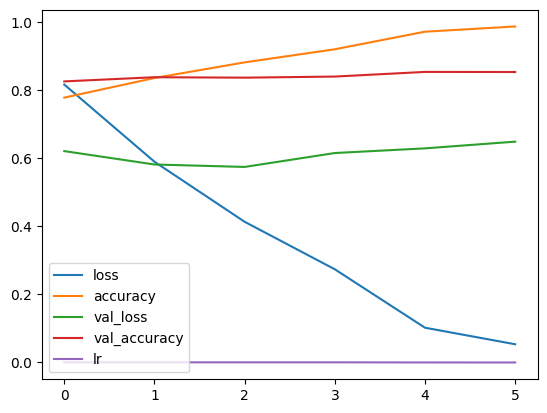

In [26]:
import pandas as pd
pd.DataFrame(history_101_food_classes_all_data_fine_tune.history).plot()

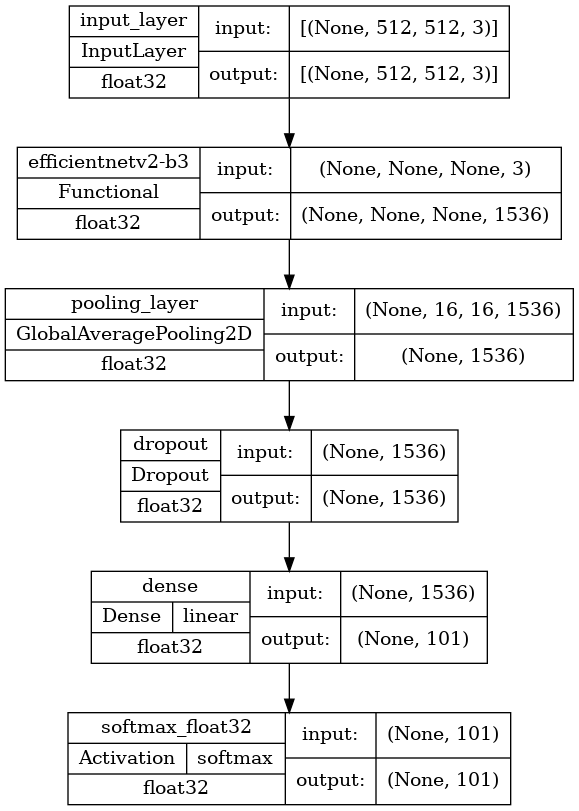

In [6]:
from tensorflow.keras.utils import plot_model
loadModel = tf.keras.models.load_model("model_84_9.h5")
plot_model(loadModel, show_shapes=True,show_dtype=True, show_layer_names=True,show_layer_activations=True)